# Purpose

The purpose of this notebook is to compare pKa and binarized sequence as predictors of drug resistance.

- Sequence Feature Tested:
    - Amino acid pKa values
    - binarized pKa values
- Model:
    - Random Forest Regressor

In [41]:
# Jupyter notebook magic statements
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')

from Bio import SeqIO
from util.isoelectric_point import *  # imported from the 'util/' directory
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelBinarizer

In [43]:
# List the files present in the "data" folder
! ls data/

20150902_nnet_ha.fasta                hiv-nnrt-data.csv                     hiv-protease-data-expanded.csv        hiv-protease.pdb
HIV-1_pol.fasta                       hiv-nrt-data.csv                      hiv-protease-data.csv                 hiv-rt-consensus.fasta
amino_acid_properties.csv             hiv-protease-consensus.fasta          hiv-protease-sequences-expanded.fasta


In [44]:
# Load the protease resistance data into memory.
# [ ] TODO: Refactor this function out as a load_data() function.
resistance = pd.read_csv('data/hiv-protease-data-expanded.csv', index_col=0)
drug_cols = ['NFV', 'SQV', 'FPV', 'IDV', 'LPV', 'ATV', 'TPV', 'DRV']
resistance.set_index('seqid', inplace=True)
resistance[drug_cols] = resistance[drug_cols].apply(np.log10)
resistance.head()

,ATV,DRV,FPV,IDV,LPV,NFV,SQV,SeqID,TPV,sequence,sequence_object,weight
seqid,,,,,,,,,,,,
2996-0,NaN,NaN,0.397940,1.212188,NaN,1.586587,1.206826,2996,NaN,PQITLWQRPIVTIKIGGQLKEALLDTGADDTVLEDVNLPGRWKPKM...,ID: 2996-0\nName: <unknown name>\nDescription:...,0.50
2996-1,NaN,NaN,0.397940,1.212188,NaN,1.586587,1.206826,2996,NaN,PQITLWQRPIVTIKIGGQLKEALLDTGADDTVLEDVNLPGRWKPKM...,ID: 2996-1\nName: <unknown name>\nDescription:...,0.50
4387-0,NaN,NaN,-0.154902,-0.096910,NaN,-0.096910,0.041393,4387,NaN,PQITLWQRPLVTIKVGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,ID: 4387-0\nName: <unknown name>\nDescription:...,0.25
4387-1,NaN,NaN,-0.154902,-0.096910,NaN,-0.096910,0.041393,4387,NaN,PQITLWQRPLVTIKVGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,ID: 4387-1\nName: <unknown name>\nDescription:...,0.25
4387-2,NaN,NaN,-0.154902,-0.096910,NaN,-0.096910,0.041393,4387,NaN,PQITLWQRPLVTIKVGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,ID: 4387-2\nName: <unknown name>\nDescription:...,0.25


In [45]:
# Count the number of NaNs in each of the drug resistance columns.
pd.isnull(resistance[drug_cols]).sum().sort_values()

NFV     111
SQV     316
FPV     319
IDV     325
LPV     930
ATV    1928
TPV    2650
DRV    4141
dtype: int64

In [46]:
# Convert the FASTA file of sequences into a pandas dataframe.
# [ ] TODO: Refactor out into a load_sequences() function.
sequences = [np.array(s) for s in SeqIO.parse('data/hiv-protease-sequences-expanded.fasta', 'fasta')]
seqids = [s.id for s in SeqIO.parse('data/hiv-protease-sequences-expanded.fasta', 'fasta')]
sequences = pd.DataFrame(sequences)
sequences = sequences.replace('*', np.nan)
sequences.index = seqids
sequences.dropna(inplace=True)

# Because there's a lower-case character somewhere, force all of the characters to be upper-case.
for col in sequences.columns:
    sequences[col] = sequences[col].apply(lambda x: str(x).upper())

In [47]:
len(sequences)

6900

In [48]:
# Commands to inspect the utility scripts
# ! ls util/
! cat util/isoelectric_point.py

"""
Author: Eric J. Ma
Date: 2015-03-17
"""

isoelectric_points = {
    'A':6.11,
    'R':10.76,
    'N':10.76,
    'D':2.98,
    'C':5.02,
    'E':3.08,
    'Q':5.65,
    'G':6.06,
    'H':7.64,
    'I':6.04,
    'L':6.04,
    'K':9.74,
    'M':5.74,
    'F':5.91,
    'P':6.30,
    'S':5.68,
    'T':5.60,
    'W':5.88,
    'Y':5.63,
    'V':6.02,
    'X':7.00,  # unknown so assign neutral
    'B':6.87,  # the average of D and N
    'Z':4.35,  # the average of E and Q
    'J':6.04,  # the average of I and L
}

def get_isoelectric_point(aa):
    return isoelectric_points[aa]

In [49]:
# Replace the letters with amino acid pKas
# Also ensure that "*" are replace with NaN, which are then dropped later.
pKa_features = sequences.replace(isoelectric_points.keys(), isoelectric_points.values())
pKa_features.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
2996-0,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,5.74,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91
2996-1,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,5.74,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91
4387-0,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,6.04,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91
4387-1,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,6.04,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91
4387-2,6.3,5.65,6.04,5.6,6.04,5.88,5.65,10.76,6.3,6.04,...,6.04,5.6,5.65,6.04,6.06,5.02,5.6,6.04,10.76,5.91


In [72]:
# Join in the resistance data for FPV

# [ ] TODO: Refactor lines 5 through 14 into a get_XY_matrix() function.
# Tunable parameters
X_cols = [i for i in range(0,99)]
drug = 'LPV'
weight_col = 'weight'

# Get the final data matrix, and split into X and Y
data_matrix = pKa_features.join(resistance[[drug, weight_col]], how='inner').dropna()
print(len(data_matrix))
X = data_matrix[X_cols]
Y = data_matrix[drug]
W = data_matrix[weight_col]

# Perform a train/test split
cv = ShuffleSplit(n=len(X), n_iter=10, test_size=0.2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Compute the following:
mdl = RandomForestRegressor(n_estimators=100)

# Compute the score as the mean absolute error
scores = cross_val_score(mdl, X, Y, cv=cv, scoring='mean_absolute_error', n_jobs=-1)
np.abs(np.mean(scores))

5970


0.070275725049439255

In [73]:
np.std(scores)

0.0041089622602374781

In [74]:
# Do a fit/predict on the X and Y matrices.
def train_random_forest_regressor(X_train, Y_train, W, X_test, Y_test):
    mdl = RandomForestRegressor(n_estimators=100)
    mdl.fit(X_train, Y_train, sample_weight=W.ix[X_train.index].values)
    preds = mdl.predict(X_test)
    score = mdl.score(X_test, Y_test)
    
    return preds, score

preds, score = train_random_forest_regressor(X_train, Y_train, W, X_test, Y_test)

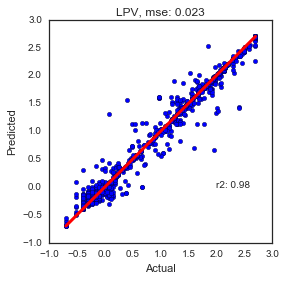

In [75]:
# Plot the predicted against actual.

def plot_test_vs_preds(Y_test, preds):
    fig = plt.figure(figsize=(4,4))
    plt.scatter(Y_test, preds)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.plot([min(Y_test),max(Y_test)], [min(Y_test),max(Y_test)], color='r', lw=3)
    plt.annotate('r2: {0:.02f}'.format(score), xy=(2,0))
    plt.title('{0}, mse: {1:.03f}'.format(drug, mse(preds, Y_test)))
    
plot_test_vs_preds(Y_test, preds)

In [76]:
# The average MSE is 0.02, which is in log-transformed units.
# The average mean absolute error is 0.08
# What is the actual mean error in non log-transformed units?
print('The actual mean error is:')
np.power(10, np.abs(np.mean(scores)))

The actual mean error is:


1.1756437111907017

## What about binarized protein sequence?

In [77]:
# We will use the scikit-learn label binarizer to binarize the amino acids into a letter matrix.
aa_letters = [i for i in isoelectric_points.keys()]

lb = LabelBinarizer()
lb.fit(aa_letters)

bin_features = pd.DataFrame()
X_cols = []

for col in sequences.columns:
    transformed = lb.transform(sequences[col])
    
    for i, letter in enumerate(lb.classes_):
        colname = '{0}_{1}'.format(col, letter)
        bin_features[colname] = transformed[:, i]
        X_cols.append(colname)

bin_features.index = sequences.index
bin_features.head()

,0_A,0_B,0_C,0_D,0_E,0_F,0_G,0_H,0_I,0_J,...,98_P,98_Q,98_R,98_S,98_T,98_V,98_W,98_X,98_Y,98_Z
2996-0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2996-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4387-0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4387-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4387-2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
data_matrix = bin_features.join(resistance[[drug, weight_col]]).dropna()
print(len(data_matrix))

X = data_matrix[X_cols]
Y = data_matrix[drug]
W = data_matrix[weight_col]

# Perform a train/test split
cv = ShuffleSplit(n=len(X), n_iter=10, test_size=0.2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Compute the following:
mdl = RandomForestRegressor(n_estimators=100)

# Compute the score as the mean absolute error
scores = cross_val_score(mdl, X, Y, cv=cv, scoring='mean_absolute_error', n_jobs=-1)
np.abs(np.mean(scores))

5970


0.066340048817844915

In [79]:
np.std(scores)

0.0043725869577109708

In [80]:
# Do a fit/predict on the X and Y matrices.
preds, score = train_random_forest_regressor(X_train, Y_train, W, X_test, Y_test)

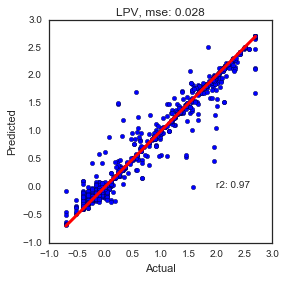

In [81]:
# Plot the predicted against actual.
plot_test_vs_preds(Y_test, preds)

In [82]:
print('The actual mean error is:')
np.power(10, np.abs(np.mean(scores)))

The actual mean error is:


1.1650378869505527

## Conclusions

Binarized sequence features vs. pKa values - basically the models perform similarly.

However, we are lacking interpretability. I would like to implement something like a [convolutional network on graphical models of chemical structures][1].

[1]: http://arxiv.org/abs/1509.09292